In [1]:
import os
from collections import defaultdict

from utils import load_embeddings, load_projects_new, load_stopwords

In [2]:
level  = '3rd'
annot = True if '1' in level else False
sz = (15,5)
max_df = 0.8
min_df = 0.1

sett = f'_{max_df}_{min_df}'

In [3]:
projects, imapping = load_projects_new('.', 'java-projects.final.csv', level=f'{level} level')
labels = {k:v for k,v in zip(projects['names'], projects['labels_id'])}
remap = {'Constraint Satisfaction Problem Solver': 'CSP Solver', 'Natural Language Processing': 'NLP', 'Scientific/Engineering': 'Science/Engineering'}

In [4]:
path = "resources/java/stopwords.txt"
stopwords = load_stopwords(path)
path = "resources/en/stopwords.txt"
stopwords.update(load_stopwords(path))

In [5]:

terms_path = '../data/embeddings/terms-count/'
mapping = {v:k for k,v in imapping.items()}

In [6]:
mapping

{3: 'Bean Mapping',
 4: 'Build',
 5: 'Bytecode Manipulation',
 8: 'Caching',
 6: 'CLI',
 9: 'Cluster Management',
 10: 'Code Analysis',
 11: 'Code Coverage',
 12: 'Code Generators',
 13: 'Compilercompiler',
 14: 'Configuration',
 15: 'Constraint Satisfaction Problem Solver',
 7: 'CSV',
 16: 'Data Structures',
 17: 'Database',
 18: 'Date and Time',
 19: 'Dependency Injection',
 20: 'Development',
 21: 'Distributed Applications',
 22: 'Distributed Transactions',
 23: 'Distribution',
 24: 'Document Processing',
 25: 'Financial',
 27: 'Formal Verification',
 29: 'Functional Programming',
 31: 'Game Development',
 32: 'Geospatial',
 30: 'GUI',
 34: 'High Performance',
 33: 'HTTP Clients',
 35: 'Hypermedia Types',
 36: 'Imagery',
 37: 'Introspection',
 40: 'Job Scheduling',
 38: 'JSON',
 39: 'JVM and JDK',
 41: 'Logging',
 42: 'Machine Learning',
 44: 'Messaging',
 45: 'Microservice',
 46: 'Miscellaneous',
 48: 'Monitoring',
 49: 'Native',
 50: 'Natural Language Processing',
 51: 'Networking

In [7]:
from textblob import  Word

data = defaultdict(str)
for project in labels:
    category = mapping[labels[project]]
    if category == 'NA':
        category = 'Miscellaneous' 

    try:
        terms_count = load_embeddings(os.path.join(terms_path, f"{project}.vec"))
        terms = []
        for x, y in terms_count.items():
            lemma = Word(x).lemmatize()
            if lemma not in stopwords and len(x) > 1 and x not in stopwords:
                tokens = [lemma] * int(y[0])
                terms.extend(tokens)
        #terms = [[Word(x).lemmatize()] * int(y[0]) for x, y in terms_count.items() if Word(x).lemmatize() not in stopwords and len(x) > 1]
        data[category] += ' ' + " ".join(terms)
    except Exception as e:
        print(e)

[Errno 2] No such file or directory: '../data/embeddings/terms-count/asm.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/infinispan.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/infer.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/source.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/org.aspectj.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/JGroups.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/checker-framework.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/libgdx.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/eclipse.platform.swt.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/reflectasm.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/flink.vec'
[Errno 2] No such file or directory: '../data/embeddings/terms-count/Smack.

In [8]:
lab = list(data.keys())
text = [data[k] for k in lab]

In [9]:
len(lab)

67

In [10]:
lab = [remap[x] if x in remap else x for x in lab]

In [11]:
len(lab)

67

In [12]:
import pandas

df = pandas.DataFrame({'text': text, 'label': lab})
#df = df[~df['label'].isin(['NA', 'Miscellaneous'])]

y = df['label'].to_frame()
X = df['text']


In [13]:
len(y)

67

In [14]:
len(X)

67

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, max_df=max_df, min_df=min_df)
#vectorizer.fit(X)
X_mat = vectorizer.fit_transform(X)

In [16]:
X_mat.shape

(67, 1000)

In [17]:
from sklearn import metrics

simil = metrics.pairwise.cosine_similarity(X_mat)

In [18]:
import numpy as np
import copy

simill = copy.deepcopy(simil)



In [19]:
simill = np.tril(simill, k=-1)


In [20]:
simill

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0404819 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01134311, 0.04080626, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01511745, 0.0723228 , 0.09428195, ..., 0.        , 0.        ,
        0.        ],
       [0.01569343, 0.02738665, 0.00258123, ..., 0.01274767, 0.        ,
        0.        ],
       [0.03404128, 0.06898155, 0.06644445, ..., 0.08416172, 0.0414547 ,
        0.        ]])

In [21]:
import csv
from itertools import combinations_with_replacement
n= simil.shape[0]
with open(f'heatmap_class_sim_{level}.csv', 'wt', encoding='utf8') as inf:
    writer = csv.writer(inf)
    for i, j in combinations_with_replacement(range(n), 2) :
        writer.writerow([lab[i], lab[j], simil[i, j]])


In [22]:
import seaborn as sns
sns.set_theme()
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
import matplotlib.pyplot as plt

In [23]:
#mask = np.zeros_like(simill, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

In [24]:
#dmask = np.zeros_like(simill, dtype=np.bool) 
#dmask[np.diag_indices_from(mask)] = True

[Text(0.5, 0, 'Bean Mapping'),
 Text(1.5, 0, 'Build'),
 Text(2.5, 0, 'Bytecode Manipulation'),
 Text(3.5, 0, 'Caching'),
 Text(4.5, 0, 'CLI'),
 Text(5.5, 0, 'Cluster Management'),
 Text(6.5, 0, 'Code Analysis'),
 Text(7.5, 0, 'Code Coverage'),
 Text(8.5, 0, 'Code Generators'),
 Text(9.5, 0, 'Compilercompiler'),
 Text(10.5, 0, 'Configuration'),
 Text(11.5, 0, 'CSP Solver'),
 Text(12.5, 0, 'CSV'),
 Text(13.5, 0, 'Data Structures'),
 Text(14.5, 0, 'Database'),
 Text(15.5, 0, 'Date and Time'),
 Text(16.5, 0, 'Dependency Injection'),
 Text(17.5, 0, 'Development'),
 Text(18.5, 0, 'Distributed Applications'),
 Text(19.5, 0, 'Distributed Transactions'),
 Text(20.5, 0, 'Distribution'),
 Text(21.5, 0, 'Document Processing'),
 Text(22.5, 0, 'Financial'),
 Text(23.5, 0, 'Formal Verification'),
 Text(24.5, 0, 'Functional Programming'),
 Text(25.5, 0, 'Game Development'),
 Text(26.5, 0, 'Geospatial'),
 Text(27.5, 0, 'High Performance'),
 Text(28.5, 0, 'HTTP Clients'),
 Text(29.5, 0, 'Hypermedia Type

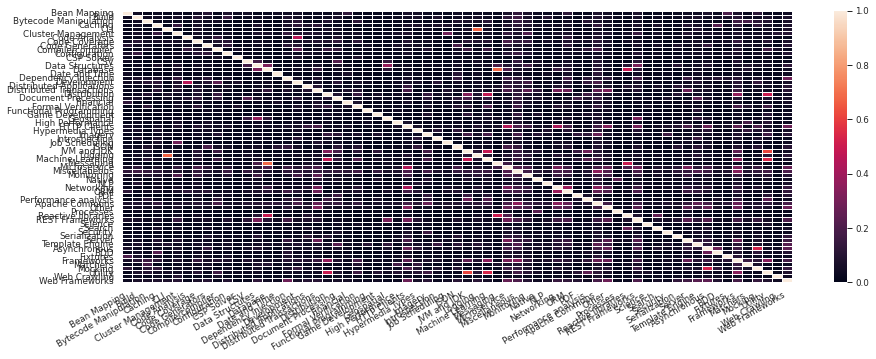

In [25]:

fig, ax = plt.subplots(figsize=sz)
a = sns.heatmap(simil, xticklabels=lab, yticklabels=lab,  annot=annot, linewidths=.5, ax=ax, vmin=0, vmax=1)
a.set_xticklabels(a.get_xticklabels(), rotation=30, horizontalalignment='right')

In [26]:
fig = a.get_figure()

fig.savefig(f'similarities_{level}.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [27]:
diag = copy.deepcopy(simil)
mask = np.zeros_like(simill, dtype=np.bool)
mask[np.diag_indices_from(mask)] = True
diag[mask] = 0
ms = np.max(diag, axis = 1)
simmin = np.min(simil)

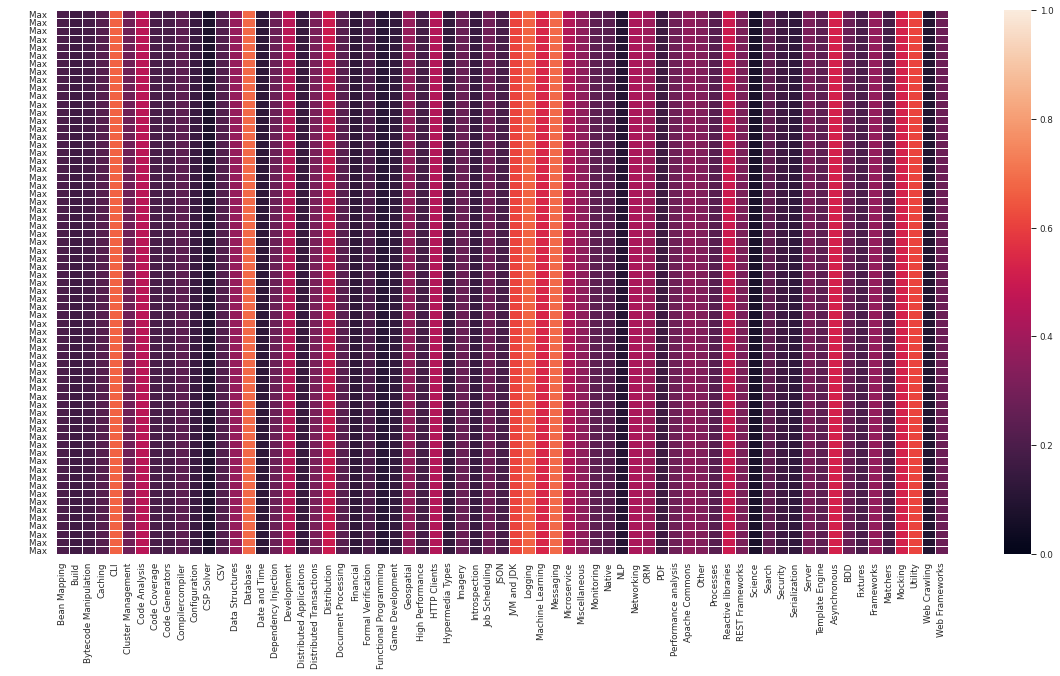

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
b = sns.heatmap([ms for i in range(len(lab))], xticklabels=lab, yticklabels=['        Max' for i in range(len(lab))], annot=annot, linewidths=.5, ax=ax, vmin=0, vmax=1)

In [29]:
fig = b.get_figure()

fig.savefig(f'max_similarities_{level}{sett}.pdf', format='pdf', dpi=1200, bbox_inches='tight')

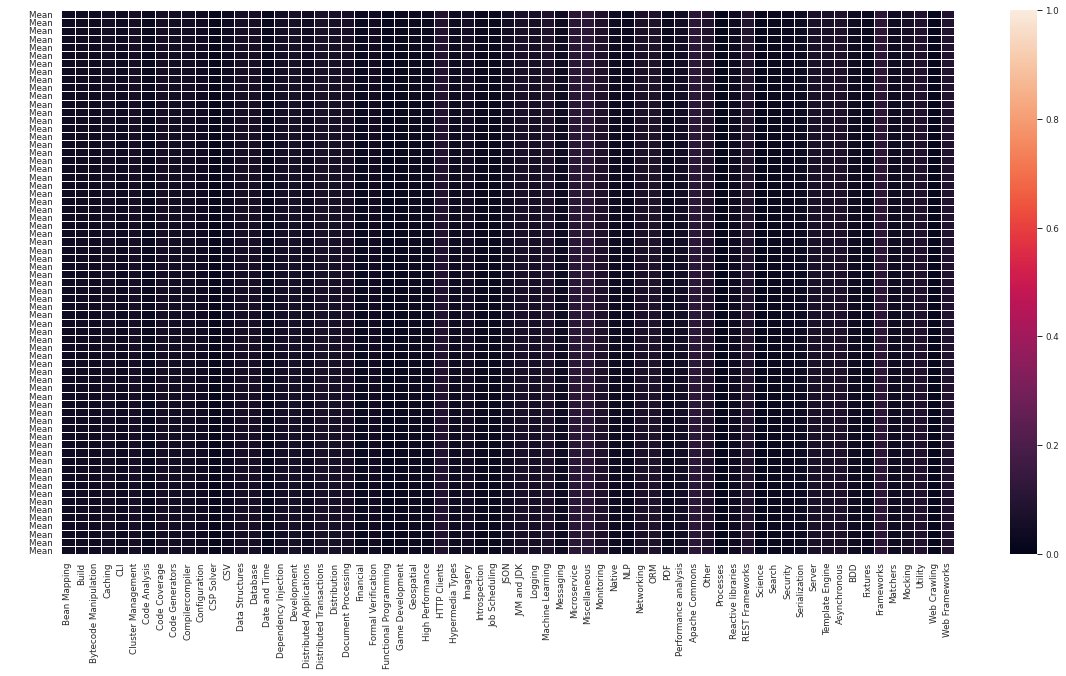

In [30]:
mdiag = copy.deepcopy(simil)
mask = np.zeros_like(simill, dtype=np.bool)
mask[np.diag_indices_from(mask)] = True
mdiag[mask] = 0
mt = np.sum(mdiag, axis=1)
mna = mt / (len(lab) - 1)
mn = np.mean(simil, axis = 1)
fig, ax = plt.subplots(figsize=(20,10))
c = sns.heatmap([mna for i in range(len(lab))], xticklabels=lab, yticklabels=['        Mean' for i in range(len(lab))], annot=annot, linewidths=.5, ax=ax, vmin=0, vmax=1)

In [31]:
fig = c.get_figure()

fig.savefig(f'mean_similarities_{level}{sett}.pdf', format='pdf', dpi=1200, bbox_inches='tight')

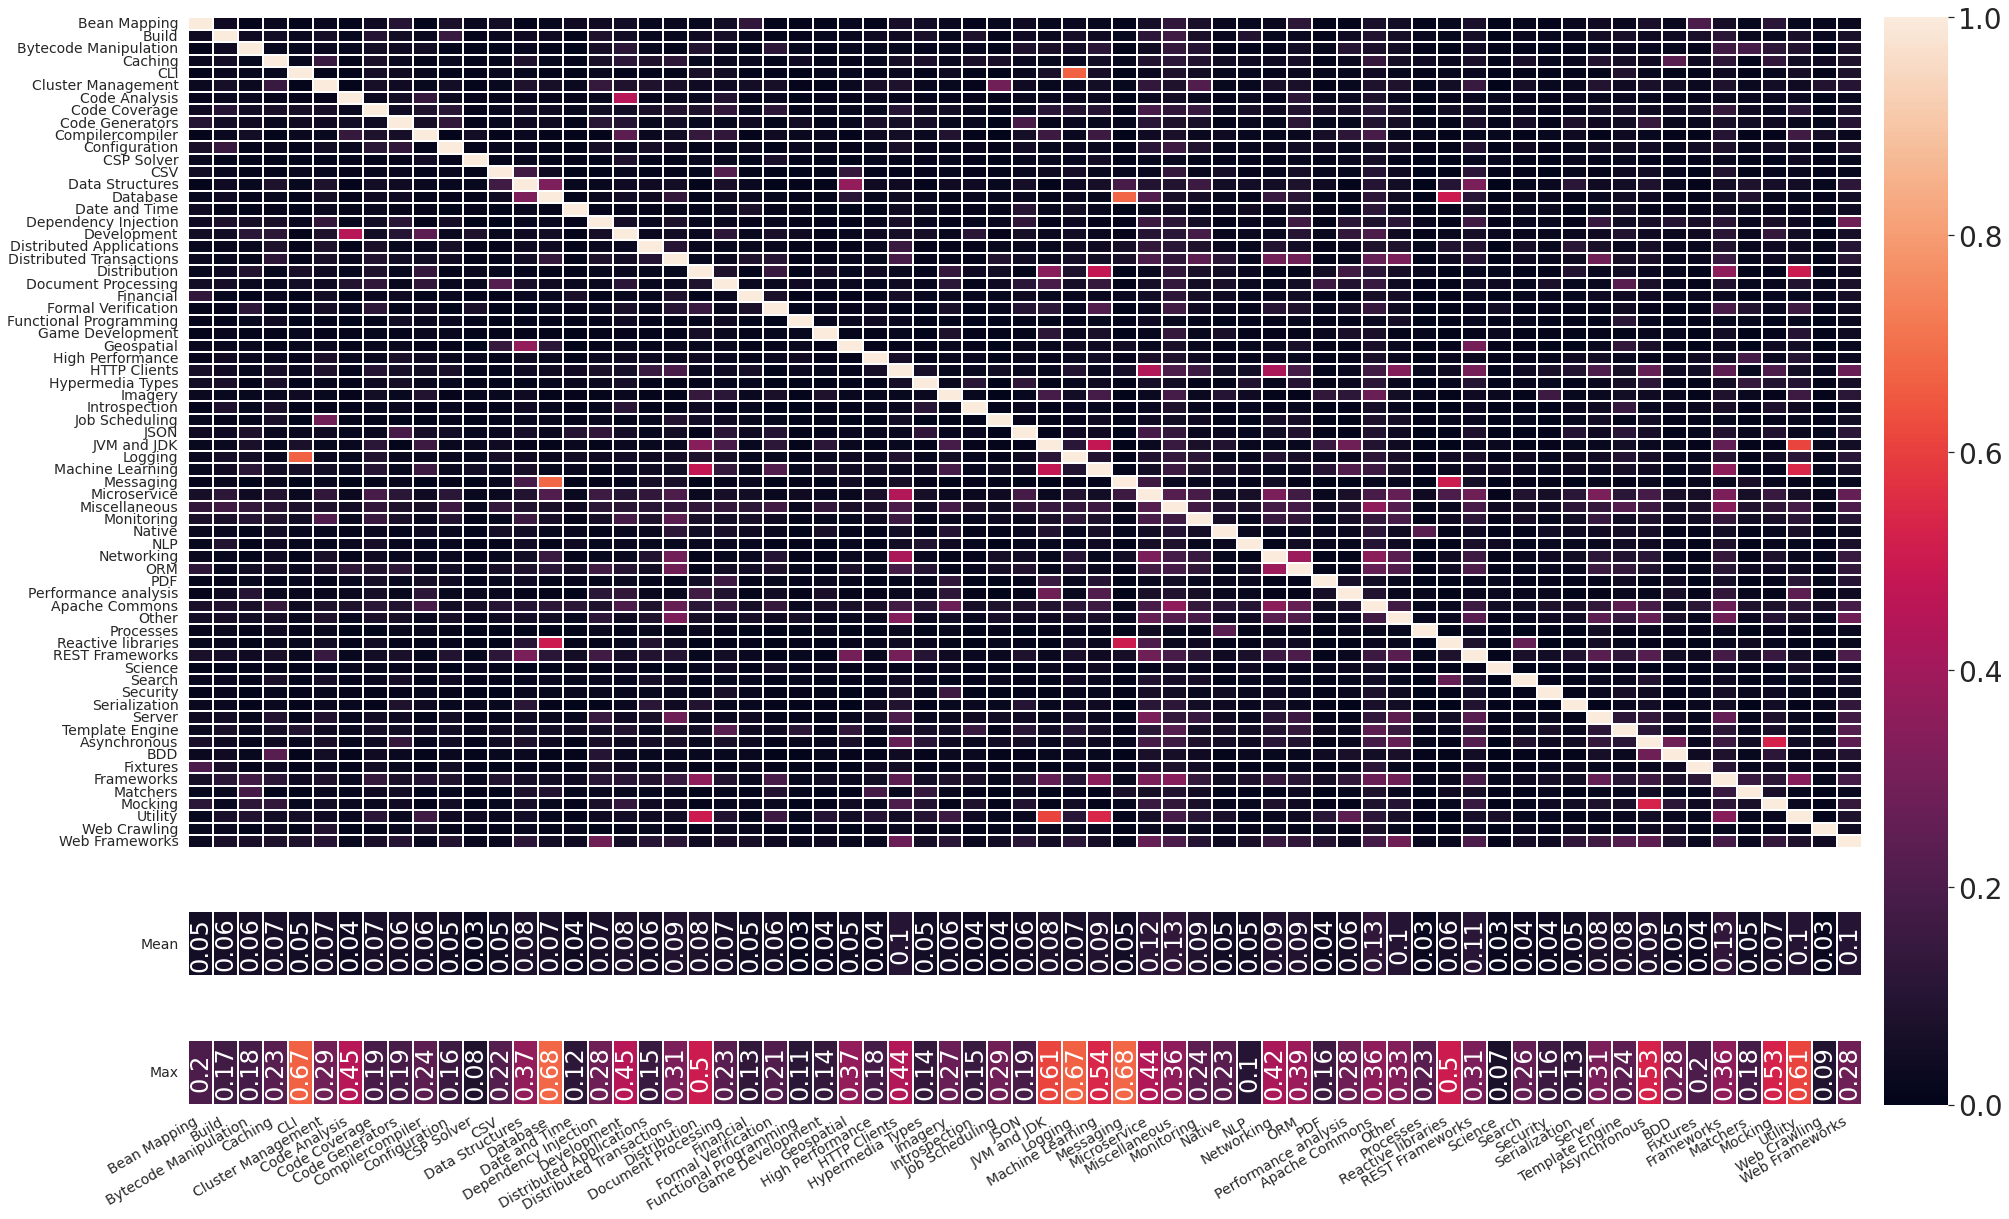

In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'size'   : 180}

matplotlib.rc('font', **font)

import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(3, 1, 
                         figsize=(30,20),
                         gridspec_kw={'height_ratios':[90, 7, 7],
                                      'width_ratios' :[20]})

cbar_ax = fig.add_axes([.91, .125, .03, .755])

#sns.set_context("paper")#, font_scale=1.6)#rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})
sns.set(font_scale=2)
fsz = 14
for i, axes in enumerate(ax.flat):                
    if i == 0:
        v = sns.heatmap(np.round(simil, decimals=2), ax=axes, cbar_ax=cbar_ax, xticklabels=[], vmin=0, vmax=1, yticklabels=lab,  annot=annot, linewidths=.3) 
        v.set_yticklabels(v.get_yticklabels(), verticalalignment='center',  size = fsz)
        cbar = v.collections[0].colorbar
        cbar.ax.tick_params(labelsize=28)
    if i == 1:
        t = sns.heatmap(np.round([mn], decimals=2), ax=axes, cbar_ax=cbar_ax, yticklabels=['Mean'], xticklabels=[], vmin=0, vmax=1, cbar=False, annot=True, annot_kws={'rotation': 90}, linewidths=.3)
        t.set_yticklabels(t.get_yticklabels(), rotation=0, verticalalignment='center',  size = fsz)
    if i == 2:
        k = sns.heatmap(np.round([ms], decimals=2), ax=axes, cbar_ax=cbar_ax, yticklabels=['Max'], xticklabels=lab, vmin=0, vmax=1, cbar=False, annot=True, annot_kws={'rotation': 90}, linewidths=.3) 
        k.set_xticklabels(k.get_xticklabels(), rotation=30, horizontalalignment='right',  size = fsz)
        k.set_yticklabels(k.get_yticklabels(), rotation=0, verticalalignment='center',  size = fsz)
fig.savefig(f'class_similarities_{level}{sett}_final.pdf', format='pdf', dpi=800, bbox_inches='tight')

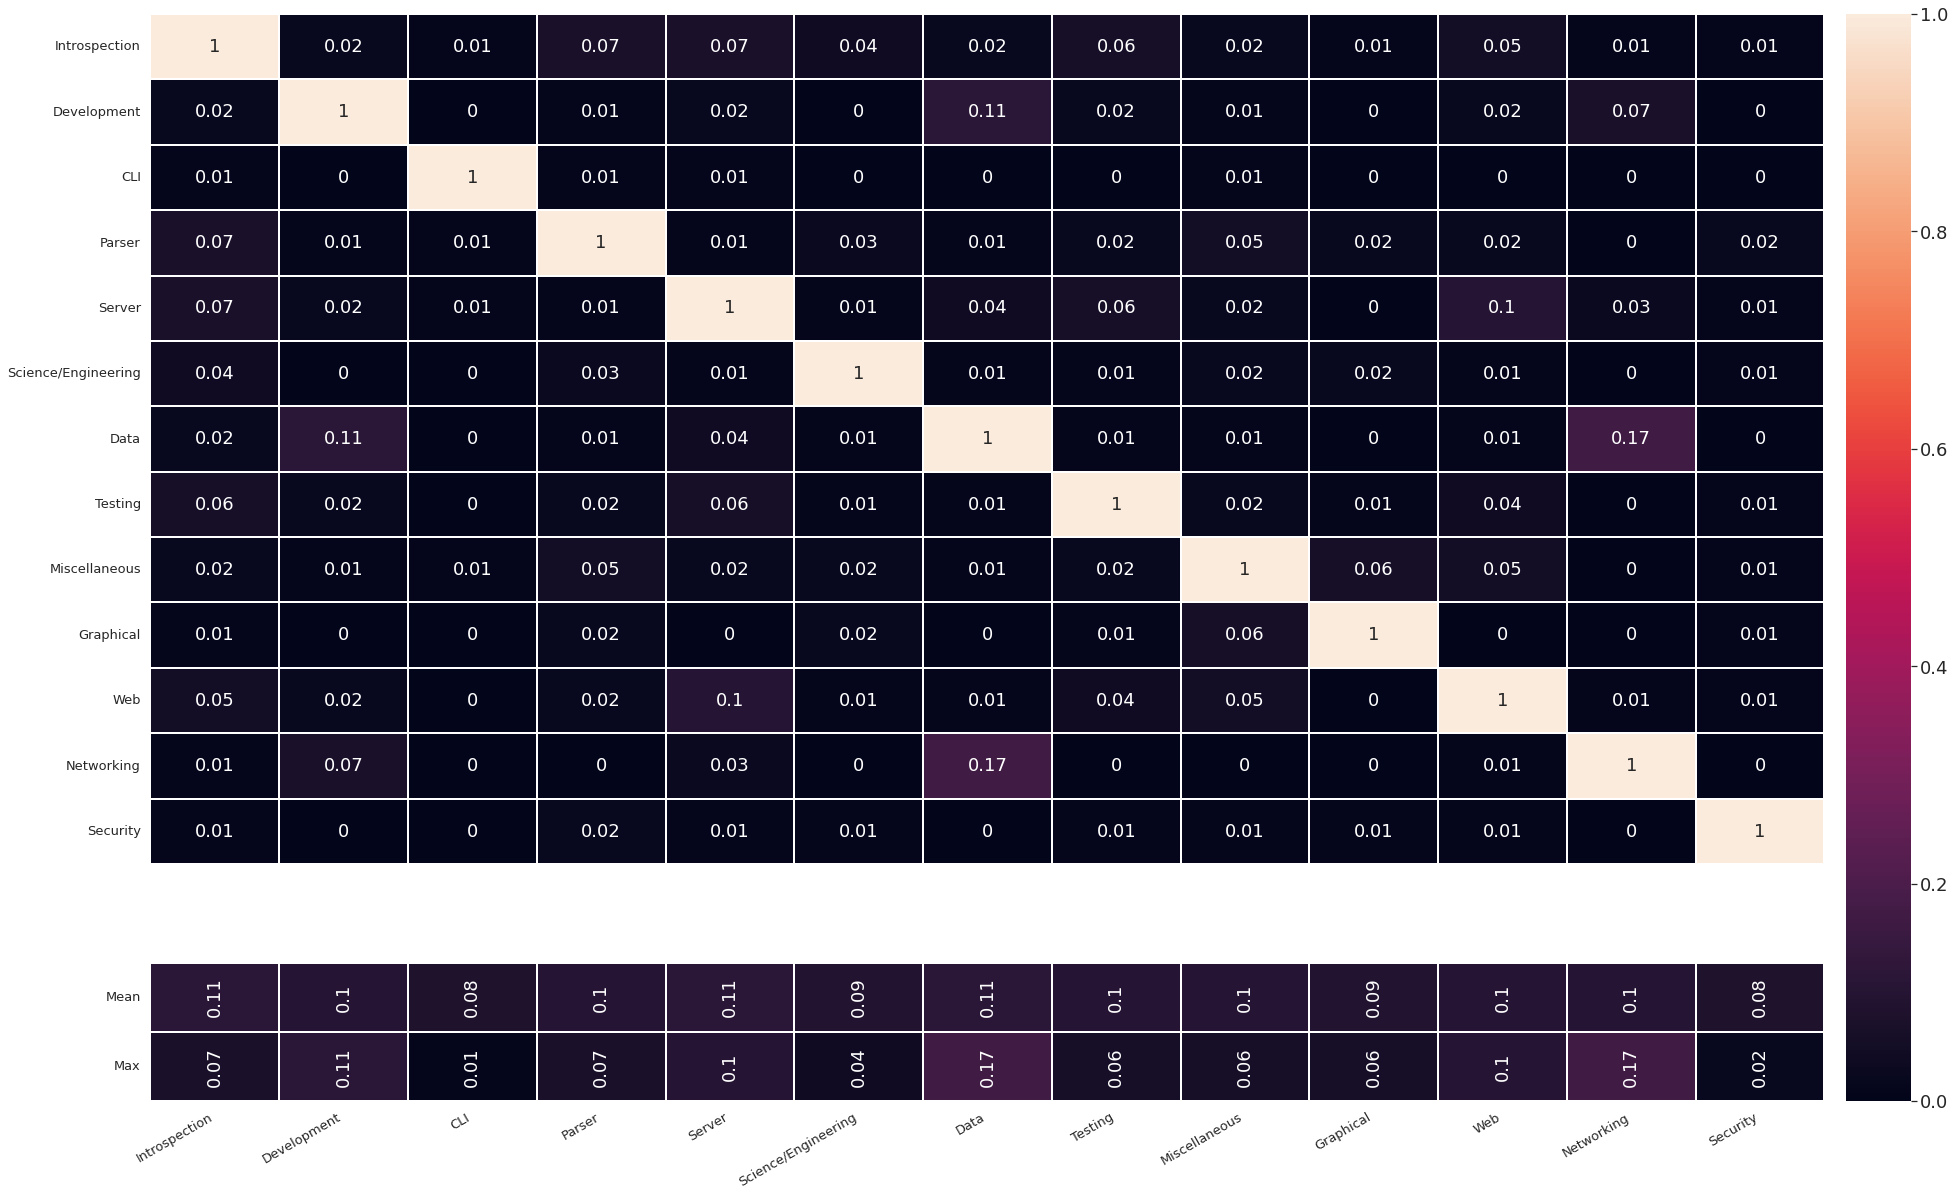

In [78]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'size'   : 60}

matplotlib.rc('font', **font)

import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(2, 1, 
                         figsize=(30,20),
                         gridspec_kw={'height_ratios':[86, 14],
                                      'width_ratios' :[20]})

cbar_ax = fig.add_axes([.91, .125, .03, .755])


#sns.set_context("paper")#, font_scale=1.6)#rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})
sns.set(font_scale=1.5)
fsz = 13
for i, axes in enumerate(ax.flat):                
    if i == 0:
        v = sns.heatmap(np.round(simil, decimals=2), ax=axes, cbar_ax=cbar_ax, xticklabels=[], vmin=0, vmax=1, yticklabels=lab,  annot=annot, linewidths=.3) 
        v.set_yticklabels(v.get_yticklabels(), verticalalignment='center',  size = fsz)
        cbar = v.collections[0].colorbar
        cbar.ax.tick_params(labelsize=18)
    if i == 1:
        k = sns.heatmap(np.round([mn, ms], decimals=2), ax=axes, cbar_ax=cbar_ax, yticklabels=['Mean', 'Max'], xticklabels=lab, vmin=0, vmax=1, cbar=False, annot=True, annot_kws={'rotation': 90}, linewidths=.3) 
        k.set_xticklabels(k.get_xticklabels(), rotation=30, horizontalalignment='right',  size = fsz)
        k.set_yticklabels(k.get_yticklabels(), rotation=0, verticalalignment='center',  size = fsz)
fig.savefig(f'class_similarities_{level}{sett}_final_test.pdf', format='pdf', dpi=1200, bbox_inches='tight')